<a href="https://colab.research.google.com/github/pazaborgs/cnn_brain_tumor_classification/blob/main/brain_tumor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Brain Tumor**

Este trabalho apresenta o desenvolvimento e a avaliação de modelos baseados em Redes Neurais Convolucionais (CNNs) para a classificação automática de tumores cerebrais em imagens de ressonância magnética (RM). Considerando a alta taxa de mortalidade associada aos tumores do Sistema Nervoso Central, a detecção precoce e precisa é fundamental para o sucesso do tratamento.

O projeto foi desenvolvido como Trabalho de Conclusão de Curso (TCC) do curso de Ciência de Dados da Universidade Virtual do Estado de São Paulo (UNIVESP), com o objetivo de testar e comparar diferentes abordagens de Deep Learning em um problema de diagnóstico médico por imagem.

## 🩻 Modelos e Metodologias

Foram implementadas duas redes neurais:

1. Uma CNN com arquitetura personalizada, desenvolvida do zero.
2. Uma CNN usando Transfer Learning, utilizando a arquitetura InceptionV3 como backbone.

## 📊 Base de Dados

Para alcançar os objetivos propostos, foi utilizada a base de dados Brain Tumor
Classification (MRI), disponível no site Kaggle, compartilhada pelo usuário Sartaj. O Kaggle é uma plataforma para cientistas de dados, especialistas em aprendizado de máquina e estudantes, onde os usuários podem competir entre si na criação de modelos robustos de aprendizado de máquina. Também funciona como um grande repositório de conjuntos de dados com enfoque em ciência de dados.

Este dataset é composto por imagens de ressonâncias magnéticas cerebrais,
categorizadas nas classes Glioma, Meningioma, Pituitário ou ausência de tumor. O dataset contém um total de 3264 imagens em formato. jpg, com variações de tamanho e predominância de tons de cinza.

[🎲 Link para o Dataset](https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri)

[📄 Link para o TCC publicado](WIP)

[👉🏽 Desenvolvedor do Código](www.linkedin.com/in/patrickrgsanjos)


## **Configuração Inicial do Ambiente**

O notebook foi desenvolvido para ser executado no ambiente Google Colaboratory (Colab), utilizando o dataset Brain Tumor Classification (MRI), carregado diretamente da plataforma Kaggle. A reprodutibilidade requer que o usuário possua uma conta ativa no Kaggle.

Para que o Colab possa baixar o dataset diretamente do repositório, é necessário fornecer seu token pessoal de API do Kaggle.

    1. Acesse sua conta no Kaggle e navegue até Account (Conta) -> Settings (Configurações)

    2. Role até a seção "API", clique em "Create New API Token" (Criar Novo Token de API).

    3. O arquivo kaggle.json será automaticamente baixado para o seu computador. Este arquivo contém suas credenciais e deve ser mantido privado. Use-o para rodar o notebook.

## **Buscando o Conjunto de Dados e Importando as Bibliotecas**

In [ ]:
# Instalando o cliente kaggle

!pip install kaggle -q

# Carregando o arquivo kaggle.json

from google.colab import files
print("⚠️ Faça o upload do seu arquivo kaggle.json:\n")
files.upload()

# Cria o diretório .kaggle se ele não existir e move o arquivo para o diretório correto

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Define as permissões necessárias

!chmod 600 ~/.kaggle/kaggle.json

print("\n✅ API configurada!")

⚠️ Por favor, faça o upload do seu arquivo kaggle.json:



Saving kaggle.json to kaggle (1).json

✅ API configurada!


In [ ]:
# Baixando o dataset do projeto e descompactando.

!kaggle datasets download -d sartajbhuvaji/brain-tumor-classification-mri
!unzip -q brain-tumor-classification-mri.zip

Dataset URL: https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri
License(s): MIT
brain-tumor-classification-mri.zip: Skipping, found more recently modified local copy (use --force to force download)
replace Testing/glioma_tumor/image(1).jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
Dataset baixado e descompactado com sucesso.


In [ ]:
# Bibliotecas padrão

import os
from warnings import filterwarnings
filterwarnings('ignore')

# Manipulação de dados

import numpy as np
import pandas as pd

# Visualização

import matplotlib.pyplot as plt
import seaborn as sns

# Processamento de Imagem

import cv2
from PIL import Image

# Machine Learning e Deep Learning

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Utilitários

from tqdm import tqdm
from IPython.display import display
from google.colab import drive

import os
from pathlib import Path
from PIL import Image
import numpy as np
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
import matplotlib.cm as cm
from PIL import Image
from IPython.display import display

## **Carregando as Imagens no Colab**

In [ ]:
# Url com o caminho para os arquivos. '.' significa diretório raiz

url = '.'

In [ ]:
# Rótulos do conjunto de dados

labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor'] # Glioma, Sem Tumor, Meningioma, Pituitário

In [ ]:
# Carregando as imagens de treino e redimensionando para 299 x 299.

X_train, y_train  = [], []  # Conjunto de Treino
img_size = 299

# Carregando da pasta "treino"

for label in labels:
  folderPath = os.path.join(url, 'Training', label)
  for file in tqdm(os.listdir(folderPath)):
      img = cv2.imread(os.path.join(folderPath, file))
      img = cv2.resize(img, (img_size, img_size))
      X_train.append(img)
      y_train.append(label)

# Carregando da pasta "teste". O conjunto de teste será criado reservando uma porcentagem do conjunto de imagens inteiro.

for label in labels:
  folderPath = os.path.join(url, 'Testing', label)
  for file in tqdm(os.listdir(folderPath)):
      img = cv2.imread(os.path.join(folderPath, file))
      img = cv2.resize(img, (img_size, img_size))
      X_train.append(img)
      y_train.append(label)

# Transformando os conjuntos de treino e teste em arrays. Esse formato é necessário para o funcionamento de modelos de aprendizado de máquina.

X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 74/74 [00:00<00:00, 343.40it/s]


## **Visualizando as Imagens e Características do Conjunto**

In [ ]:
print("O Formato das Imagens é:\n\nNúmero de Imagens Total: {}\nDimensões: {} x {}\nProfundidade: {}".format(X_train.shape[0], X_train.shape[1], X_train.shape[2], X_train.shape[3]))

O Formato das Imagens é:

Número de Imagens Total: 3264
Dimensões: 299 x 299
Profundidade: 3


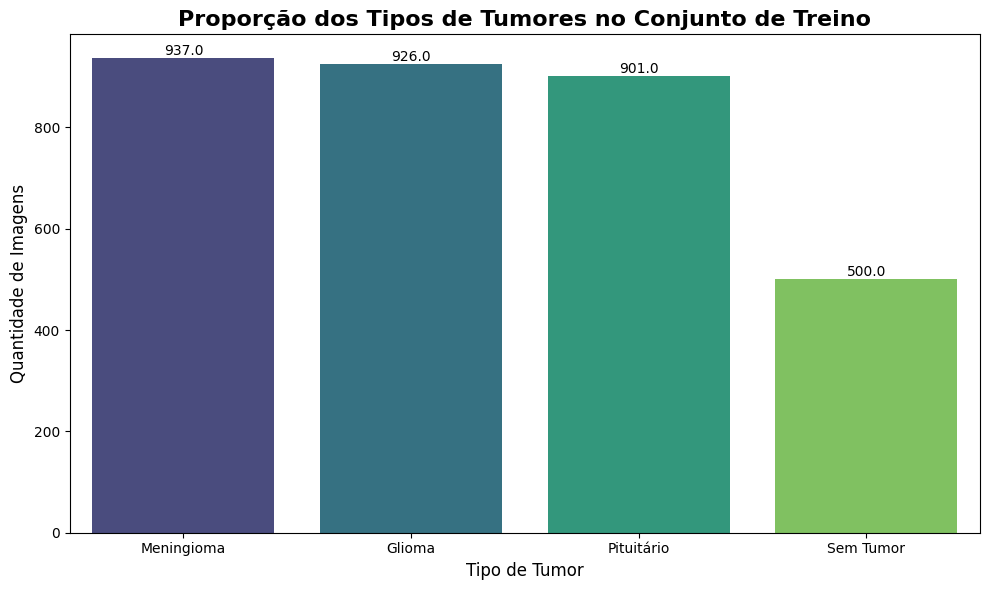

In [ ]:
# Gráfico para mostrar a proporção dos tipos de tumores no conjunto

# Rótulos traduzidos

map_labels = {
    'glioma_tumor': 'Glioma',
    'no_tumor': 'Sem Tumor',
    'meningioma_tumor': 'Meningioma',
    'pituitary_tumor': 'Pituitário'
}

y_train_labels = pd.Series(y_train).map(map_labels)

plt.figure(figsize=(10, 6))
ax = sns.countplot(x = y_train_labels, order =  y_train_labels.value_counts().index, palette='viridis')

# Contagem acima das barras

for p in ax.patches:
    ax.annotate(f'{p.get_height()}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                fontsize=10, color='black',
                xytext=(0, 5),
                textcoords='offset points')

# Título e eixos

plt.title('Proporção dos Tipos de Tumores no Conjunto de Treino', fontsize=16, fontweight='bold')
plt.xlabel('Tipo de Tumor', fontsize=12)
plt.ylabel('Quantidade de Imagens', fontsize=12)
ax.set_title('Proporção dos Tipos de Tumores no Conjunto de Treino', fontsize=16, fontweight='bold')
ax.set_xlabel('Tipo de Tumor', fontsize=12)
ax.set_ylabel('Quantidade de Imagens', fontsize=12)

plt.tight_layout()
plt.show()

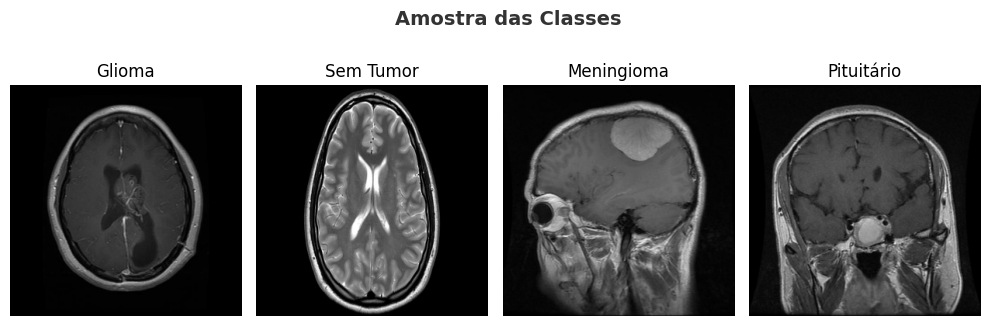

In [ ]:
# Visualizando uma amostra das imagens

k = 0
fig, ax = plt.subplots(1, 4, figsize=(10, 8))
fig.text(s = 'Amostra das Classes', size = 14, fontweight = 'bold', y = 0.62, x=0.4, alpha=0.8)

for i in labels:
  j = 0
  while True:
    if y_train[j] == i: # devolve a primeira imagem no conjunto igual ao rótulo i
        # Plot
        ax[k].imshow(X_train[j])
        ax[k].set_title(map_labels[y_train[j]])
        ax[k].axis('off')
        k += 1
        break
    j+=1

plt.tight_layout(rect=[0, 0, 1, 0.8])
plt.show()

## **Pré-Processamento**

In [ ]:
# Embaralhando os dados para divisão. Ajuda na performance do treinamento.

X_train, y_train = shuffle(X_train, y_train, random_state = 12)

In [ ]:
# Separando o conjunto de imagens em treino e teste

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.1, random_state = 12)

In [ ]:
# Definindo pesos para classes menos proeminente. Nesse caso, a classe sem tumor (500 amostras)

class_weights = {
    0: 0.8,  # glioma_tumor
    1: 1.2,  # no_tumor
    2: 0.8,  # meningioma
    3: 0.8   # pituitary_tumor
}

In [ ]:
# One Hot Encoding para o conjunto de treino

y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)

In [ ]:
# One Hot Encoding para o conjunto de teste

y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

## **Data Augmentation, Variáveis e Callbacks**

### Variáveis de Controle

In [ ]:
batch_size = 32       # Tamanho do lote que a rede vai analisar antes de mudar seus parâmetros internos
epochs = 20           # Num. de épocas que a rede vai treinar
optimizer = Adam()    # Otimizador Adam

### Gerador de Imagens para CNN Personalizada

---



In [ ]:
# Configurando os geradores para CNN personalizada, treino e teste

cnn_train_datagen = ImageDataGenerator(

    rescale = 1./255,     # Normalização: 1/255. Isso varia quando comparado com o gerador de imagens para o InceptionV3, que trabalha com outro tipo de normalização.
    rotation_range = 30,
    zoom_range = 0.1,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.1,
    horizontal_flip = True,
    vertical_flip = False,
    fill_mode = 'nearest',
    validation_split = 0.1
)

cnn_test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# Inicializando os geradores: treino, validação (variação de treino) e teste

cnn_train_generator = cnn_train_datagen.flow(
    X_train, y_train,
    batch_size = batch_size,
    shuffle = True,
    subset = "training",
)

cnn_val_generator = cnn_train_datagen.flow(
    X_train, y_train,
    batch_size = batch_size,
    shuffle = False,
    subset = "validation",
)

cnn_test_generator = cnn_test_datagen.flow(
    X_test, y_test,
    batch_size = batch_size,
    shuffle=False
)

### Gerador de Imagens para o InceptionV3

In [ ]:
# Configurando os geradores para o InceptionV3, treino e teste


tf_train_datagen = ImageDataGenerator(

    preprocessing_function = preprocess_input,      # Normalização personalizada: preprocess_input
    rotation_range = 30,
    zoom_range = 0.1,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.1,
    horizontal_flip = True,
    vertical_flip = False,
    fill_mode = 'nearest',
    validation_split = 0.1
)


tf_test_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)

In [ ]:
# Inicializando os geradores: treino, validação (variação de treino) e teste.

tf_train_generator = tf_train_datagen.flow(
    X_train, y_train,
    batch_size = batch_size,
    shuffle = True,
    subset = "training",
)


tf_val_generator = tf_train_datagen.flow(
    X_train, y_train,
    batch_size = batch_size,
    shuffle = False,
    subset = "validation",
)

tf_test_generator = tf_test_datagen.flow(
    X_test, y_test,
    batch_size = batch_size,
    shuffle = False
)

### Callbacks e Gráfico de Avaliação

In [ ]:
# Callbacks

callbacks = [
    EarlyStopping(monitor = 'val_loss', patience=7, restore_best_weights = True),                      # Para o treinamento se a validação não melhorar em 7 épocas
    ReduceLROnPlateau(monitor = 'val_loss', factor = 0.5, patience = 2, min_lr = 1e-6, verbose = 1),   # Altera a taxa de aprendizado, respeitando um limite mínimo, se não melhorar em 2 épocas.
]

In [ ]:
# Gráficos para avaliar Acurácia e Perda dos conjuntos de treino e validação

def plot_results(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  plt.figure(figsize=(10, 4))
  plt.subplot(1, 2, 1)
  plt.plot(acc)
  plt.plot(val_acc)

  plt.title('Acurácia do Treino x Validação')
  plt.xlabel('Épocas')
  plt.ylabel('Acurácia')
  plt.legend(['Treino', 'Validação'], loc = 'upper left')

  plt.subplot(1, 2, 2)
  plt.plot(loss)
  plt.plot(val_loss)

  plt.title('Perda do Treino x Validação')
  plt.xlabel('Épocas')
  plt.ylabel('Perda')
  plt.legend(['Treino', 'Validação'], loc='upper right')

# **TESTES**

## **Teste A - CNN Personalizada**

In [ ]:
model_cnn = Sequential([

    # Camadas Convolucionais

    Conv2D(filters=32, kernel_size=(5, 5), padding='same', use_bias=False, input_shape=(img_size, img_size, 3)), # use-bias = false, pois BatchNorm. faz o bias ser irrelevante
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),

    # Bloco 2
    Conv2D(filters=32, kernel_size=(3, 3), padding='same', use_bias=False),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),

    # Bloco 3
    Conv2D(filters=64, kernel_size=(3, 3), padding='same', use_bias=False),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),

    # Bloco 4
    Conv2D(filters=64, kernel_size=(3, 3), padding='same', use_bias=False),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    # Camada de Classificação

    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(4, activation='softmax')

        ])

# Compilação: Otimizador Adam, Entropia Cruzada Categórica

model_cnn.compile(
    optimizer=optimizer,
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model_cnn.summary() # Sumário

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 299, 299, 32)   │         2,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 299, 299, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 299, 299, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 149, 149, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 149, 149, 32)   │         9,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 149, 149, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 149, 149, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 74, 74, 64)     │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 74, 74, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 74, 74, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 37, 37, 64)     │        36,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 37, 37, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 18, 18, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 18, 18, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 20736)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,654,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 2,723,044 (10.39 MB)

 Trainable params: 2,722,404 (10.39 MB)

 Non-trainable params: 640 (2.50 KB)

In [ ]:
# Treinamento

history = model_cnn.fit(
    cnn_train_generator,
    epochs = epochs,
    validation_data = cnn_val_generator,
    callbacks = callbacks,
    class_weight = class_weights,
    verbose = 1,
)

Epoch 1/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 100s 1s/step - accuracy: 0.4539 - loss: 1.3526 - val_accuracy: 0.3686 - val_loss: 1.5820 - learning_rate: 0.0010
Epoch 2/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.5895 - loss: 0.9256 - val_accuracy: 0.1570 - val_loss: 2.5482 - learning_rate: 0.0010
Epoch 3/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 740ms/step - accuracy: 0.6355 - loss: 0.7734
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
83/83 ━━━━━━━━━━━━━━━━━━━━ 71s 853ms/step - accuracy: 0.6355 - loss: 0.7736 - val_accuracy: 0.1502 - val_loss: 4.7756 - learning_rate: 0.0010
Epoch 4/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 74s 897ms/step - accuracy: 0.6699 - loss: 0.7261 - val_accuracy: 0.3788 - val_loss: 2.6882 - learning_rate: 5.0000e-04
Epoch 5/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 819ms/step - accuracy: 0.7109 - loss: 0.6444
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
83/83 ━━━━━━━━━━━━━━━━━━━━ 75s 907ms/step - accuracy: 0.7110 - loss: 0.6444 

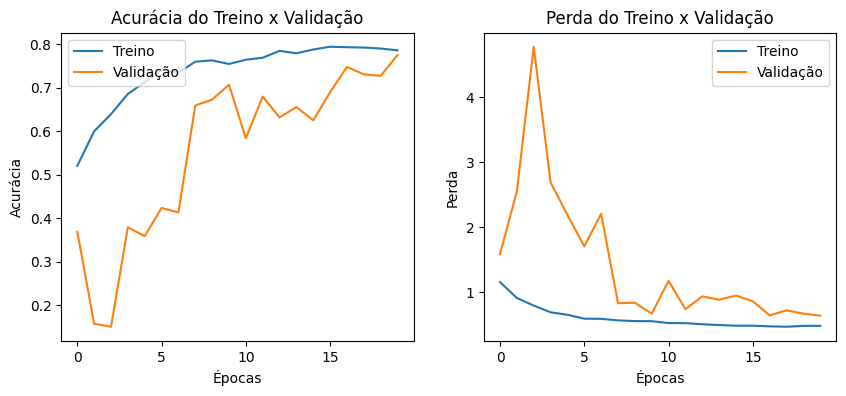

In [ ]:
# Gráficos de Acurácia e Perda

plot_results(history)

In [ ]:
# Pred

y_pred_prob = model_cnn.predict(cnn_test_generator) # Probabilidades
y_pred = np.argmax(y_pred_prob, axis=1)             # Classes Preditas
y_true = np.argmax(y_test, axis=1)                  # Classes Reais

print("\nRelatório de Classificação\n")
print(classification_report(y_true, y_pred))


11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 165ms/step

Relatório de Classificação

              precision    recall  f1-score   support

           0       0.70      0.77      0.73        84
           1       0.68      0.85      0.76        55
           2       0.80      0.37      0.50       106
           3       0.71      1.00      0.83        82

    accuracy                           0.71       327
   macro avg       0.72      0.75      0.71       327
weighted avg       0.73      0.71      0.69       327



In [ ]:
# Matriz de Confusão

cm = confusion_matrix(y_true, y_pred)

# Display

display = ConfusionMatrixDisplay(confusion_matrix = cm)
display.plot(cmap = "crest")
plt.title("Matriz de Confusão - CNN Personalizada", fontsize=12, pad=10)
plt.xlabel("Classes Preditas")
plt.ylabel("Classes Reais")
plt.show()

# **Teste B - Transfer Learning: InceptionV3**

In [ ]:
# Baixando o InceptionV3

base_model = tf.keras.applications.InceptionV3(input_shape = (img_size, img_size, 3),
                                                include_top=False,
                                                weights='imagenet')

In [ ]:
# Congela os pesos do modelo pré-treinado

base_model.trainable = False

In [ ]:
# Usando a arquitetura somente até a camada "mixed10"

ll = base_model.get_layer('mixed10').output

In [ ]:
# Camadas densas personaliuzadas

x = GlobalAveragePooling2D()(ll)
x = Dense(128)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)

# Saída

output = tf.keras.layers.Dense(4, activation='softmax')(x)

In [ ]:
# Anexando a arquitetura pré-treinada a saída densa personalizada

model_tf = tf.keras.Model(inputs = base_model.input, outputs = output)

#model_tf.summary()     # Sumário

In [ ]:
# Compilação

model_tf.compile(optimizer = Adam(),
                 loss = 'categorical_crossentropy',
                 metrics = ['accuracy'])

In [ ]:
# Importante para rodar sem erros

tf.config.run_functions_eagerly(True)

In [ ]:
# Treinamento

history = model_tf.fit(
    tf_train_generator,
    epochs = epochs,
    validation_data = tf_val_generator,
    callbacks = callbacks,
    class_weight = class_weights,
    verbose=1,
)

Epoch 1/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 115s 1s/step - accuracy: 0.5821 - loss: 0.9727 - val_accuracy: 0.7133 - val_loss: 0.7653 - learning_rate: 0.0010
Epoch 2/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 107s 1s/step - accuracy: 0.7914 - loss: 0.4596 - val_accuracy: 0.8123 - val_loss: 0.4688 - learning_rate: 0.0010
Epoch 3/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 110s 1s/step - accuracy: 0.8113 - loss: 0.4099 - val_accuracy: 0.7816 - val_loss: 0.5394 - learning_rate: 0.0010
Epoch 4/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 109s 1s/step - accuracy: 0.8456 - loss: 0.3687 - val_accuracy: 0.8259 - val_loss: 0.4173 - learning_rate: 0.0010
Epoch 5/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 108s 1s/step - accuracy: 0.8430 - loss: 0.3447 - val_accuracy: 0.8430 - val_loss: 0.4020 - learning_rate: 0.0010
Epoch 6/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 105s 1s/step - accuracy: 0.8564 - loss: 0.3124 - val_accuracy: 0.8498 - val_loss: 0.3920 - learning_rate: 0.0010
Epoch 7/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 108s 1s/step - accuracy: 0.8480 - loss: 0.3253 - val_acc

In [ ]:
# Pred

y_pred_prob = model_tf.predict(tf_test_generator)  # Probabilidades
y_pred = np.argmax(y_pred_prob, axis=1)             # Classes Preditas
y_true = np.argmax(y_test, axis=1)                  # Classes Reais

print("\nRelatório de Classificação\n")
print(classification_report(y_true, y_pred))

11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 359ms/step

Relatório de Classificação

              precision    recall  f1-score   support

           0       0.83      0.86      0.84        84
           1       0.84      0.96      0.90        55
           2       0.89      0.81      0.85       106
           3       0.95      0.93      0.94        82

    accuracy                           0.88       327
   macro avg       0.88      0.89      0.88       327
weighted avg       0.88      0.88      0.88       327



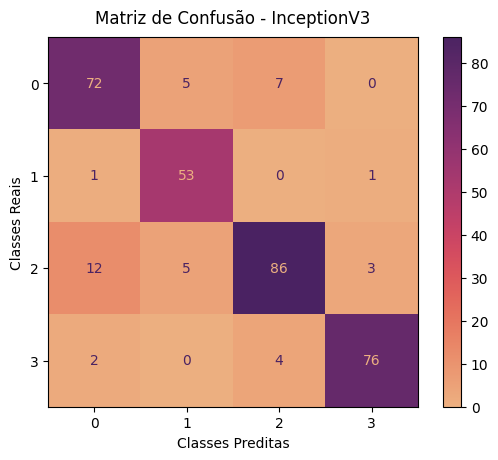

In [ ]:
# Matriz de Confusão

cm = confusion_matrix(y_true, y_pred)

# Display

display = ConfusionMatrixDisplay(confusion_matrix = cm)
display.plot(cmap = "flare")
plt.title("Matriz de Confusão - InceptionV3", fontsize=12, pad=10)
plt.xlabel("Classes Preditas")
plt.ylabel("Classes Reais")
plt.show()

# GRAD CAM

O Mapeamento de Ativação de Classe Ponderado por Gradiente (Grad-CAM) é uma técnica em aprendizado profundo e visão computacional que ajuda a visualizar as áreas de uma imagem nas quais uma rede neural convolucional (CNN) se concentra ao fazer previsões.

In [ ]:
# Caminhos para as pastas de entrada e saída


train_folder = url + "/trainin"
output_folder = url + "/gradcam_results"
print("Imagens de Treino: {} \nHeatmaps: {}".format(train_folder, output_folder))

# Definir o número máximo de imagens por classe
max_images_per_class = 1  # Você pode modificar esse valor conforme necessário
last_conv_layer_name = "mixed10"

In [ ]:

# Initialize a list to hold the image arrays
imgs_arrays = []

# Loop through each subfolder in the train_folder
for subfolder in Path(train_folder).iterdir():
    if subfolder.is_dir():  # Ensure it's a directory
        # Get the first image in the subfolder
        image_files = list(subfolder.glob('*'))  # Get all files in the subfolder
        if image_files:  # Check if there are any images
            first_image_path = image_files[0]  # Select the first image
            # Open the image file
            image = Image.open(first_image_path)

            image = image.resize((img_size, img_size))

            # Convert the image to a numpy array
            image_array = np.asarray(image)

            # Normalize the image if the max pixel value is greater than 1
            if image_array.max() > 1:
                image_array = image_array / 255.0

            # Append the image array to the list
            imgs_arrays.append(image_array)

# Convert the list of image arrays into a numpy array
imgs_arrays = np.array(imgs_arrays)

# Print the shape of the resulting numpy array
print(imgs_arrays.shape)


In [ ]:
# Funções do GRAD-CAM

def prepare_image(img_path, target_size=(img_size, img_size)):
    """Carrega e pré-processa uma imagem para o formato do modelo."""
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    """Gera o heatmap do Grad-CAM a partir de uma imagem processada."""
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path, alpha=0.7):
    """Sobrepõe o heatmap na imagem original, salva e exibe o resultado."""
    img = image.load_img(img_path)
    img_array = image.img_to_array(img)

    heatmap = np.uint8(255 * heatmap)
    jet = cm.get_cmap("hot")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img_array.shape[1], img_array.shape[0]))
    jet_heatmap = image.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img_array
    superimposed_img = image.array_to_img(superimposed_img)

    superimposed_img.save(cam_path)
    display(Image.open(cam_path))

In [ ]:
# Inicia o Processo

def process_images_in_folders(train_path, output_path, model, conv_layer_name, max_images):
    """Itera sobre as pastas, processa imagens e salva os resultados do Grad-CAM."""
    os.makedirs(output_path, exist_ok=True)
    print(f"Resultados serão salvos em: {output_path}")

    for folder_name in sorted(os.listdir(train_path)):
        folder_path = os.path.join(train_path, folder_name)

        if os.path.isdir(folder_path):
            print(f"\nProcessando pasta: {folder_name}")
            output_class_folder = os.path.join(output_path, folder_name)
            os.makedirs(output_class_folder, exist_ok=True)

            images_processed = 0
            for img_name in sorted(os.listdir(folder_path)):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    if images_processed >= max_images:
                        print(f"  Limite de {max_images} imagens atingido para a pasta.")
                        break

                    try:
                        img_path = os.path.join(folder_path, img_name)
                        print(f"  Processando: {img_name}")

                        img_array = prepare_image(img_path)
                        heatmap = make_gradcam_heatmap(img_array, model, conv_layer_name)

                        cam_filename = f"{os.path.splitext(img_name)[0]}_heatmap.jpg"
                        cam_path = os.path.join(output_class_folder, cam_filename)

                        save_and_display_gradcam(img_path, heatmap, cam_path)
                        images_processed += 1
                    except Exception as e:
                        print(f"  ERRO ao processar a imagem {img_name}: {e}")

In [ ]:
# Execução

if __name__ == '__main__':
    # Carrega o modelo pré-treinado
    inception_model = InceptionV3(weights='imagenet')

    # Inicia o processo
    process_images_in_folders(
        train_path=TRAIN_FOLDER,
        output_path=OUTPUT_FOLDER,
        model=inception_model,
        conv_layer_name=LAST_CONV_LAYER_NAME,
        max_images=MAX_IMAGES_PER_CLASS
    )
    print("\nProcessamento concluído.")